In [1]:
import tensorflow
import pandas as pd
import time
import numpy as np

# ignore all info and warnings but not error messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

# tensorflow libraries
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

# sklearn libraries are useful for preprocessing, performance measures, etc.
from sklearn import preprocessing
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split

# Read Data

In [2]:
df = pd.read_csv('./features_30_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [3]:
df['label'].value_counts()

blues        100
classical    100
country      100
disco        100
hiphop       100
jazz         100
metal        100
pop          100
reggae       100
rock         100
Name: label, dtype: int64

Split and scale dataset

In [4]:
columns_to_drop = ['label','filename', 'length']

def prepare_dataset(df, columns_to_drop, test_size, random_state):

    # Encode the labels from 0 to n_classes-1  
    label_encoder = preprocessing.LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])
  
    # devide data to train and test
    df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    
    # scale the training inputs
    x_train = df_train.drop(columns_to_drop,axis=1)
    y_train = df_train['label'].to_numpy()
    
    standard_scaler = preprocessing.StandardScaler()
    x_train_scaled = standard_scaler.fit_transform(x_train)

    #scale and prepare testing data
    x_test = df_test.drop(columns_to_drop,axis=1)
    x_test_scaled = standard_scaler.transform(x_test)
    y_test = df_test['label'].to_numpy() 
  
    return x_train_scaled, y_train, x_test_scaled, y_test

In [5]:
x_train, y_train, x_test, y_test = prepare_dataset(df, columns_to_drop, test_size=0.3, random_state=0)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(700, 57) (700,)
(300, 57) (300,)


# Q1

For all parts, `train`, `valid`, `test` will be defined as follows:

`train`:
- data that network weights are updated after seeing

`valid`:
- data that network weights are **NOT** updated after seeing

`test`:
- data that network will only see only once to evaluate generability
    - either with `model.evaluate()`
    - or training on (`train` + `valid`), validating on `test` after cross validation
        - to get better estimate of model performance with chosen hyperparameters

As seen below,
```python
y_valid[2] == 2 # integer
```
instead of something like
```python
y_valid == [0 1 0 0 0] # one hot
```
so `sparse_categorical_crossentropy` should be used as opposed to `categorical_crossentropy`

In [6]:
x_valid = x_test
y_valid = y_test
classes = len(df['label'].unique())
y_valid[2]

2

In [7]:
def run_network(
    train=(x_train, y_train),
    valid=(x_valid, y_valid),
    dropout=.3,
    neurons=16,
    batch_size=1,
    epochs=50,
    verbose=0,
    callbacks=[],
    summary=False
):
    # clear previous models
    tf.keras.backend.clear_session()
    
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(x_train.shape[1])),
        tf.keras.layers.Dense(neurons, 'relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(classes)
    ])
    if summary:
        return model.summary()
    
    model.compile(
        tf.optimizers.Adam(),
        metrics='accuracy',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) # for efficiency
    )
    return model.fit(
        x=train[0],
        y=train[1],
        verbose=verbose,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        validation_data=valid
    )

Model architecture

In [8]:
history = run_network(summary=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                928       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                170       
Total params: 1,098
Trainable params: 1,098
Non-trainable params: 0
_________________________________________________________________


In [9]:
%%time
history = run_network()

CPU times: user 2min 1s, sys: 14.1 s, total: 2min 15s
Wall time: 1min 16s


In [10]:
import matplotlib.pyplot as plt
def plot(history, suptitle_label=''):
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    f.subplots_adjust(top=.75 if suptitle_label == '' else .7)

    accuracy = history['accuracy']
    loss = history['loss']
    val_accuracy = history['val_accuracy']
    val_loss = history['val_loss']
    
    axes[1].plot(history['accuracy'])
    axes[1].plot(history['val_accuracy'])
    axes[1].set_title('Model accuracy')
    axes[1].set(ylabel = 'accuracy', xlabel = 'Epoch')
    axes[1].legend(['Train', 'Valid'], loc='upper left')
    axes[0].plot(history['loss'])
    axes[0].plot(history['val_loss'])
    axes[0].set_title('Model loss')
    axes[0].set(ylabel = 'Loss', xlabel = 'Epoch')
    axes[0].legend(['Train', 'Valid'], loc='upper left')
    axes[0].grid()
    axes[1].grid()
    
    title = (
        suptitle_label +
        'Min Training loss: {:.{}f}\n'.format(np.min(loss), 3) +
        'Max Training accuracy: {:.{}f}\n'.format(np.max(accuracy), 3) +
        'Min Validation loss: {:.{}f}\n'.format(np.min(val_loss), 3) +
        'Max Validation accuracy: {:.{}f}\n'.format(np.max(val_accuracy), 3)
    )
    f.suptitle(title)

Observations:
- for both loss and accuracy:
    - `valid` diverges from `train` at around epoch 10
- loss diverges a lot more than accuracy

Insights:
- model starts overfitting around epoch 10
    - memorizing `train`
    - learning information (weights updated) that does not generalise to predicting `valid`
- large divergence in loss does not mean large divergence in accuracy
    - not inversely related (although this is intuitive)
    - predictions may become more uncertain
        - probability of predicting `1` when class is indeed `1` decreases but is still the most probable when compared against the other classes, so accuracy may plateau while loss increases

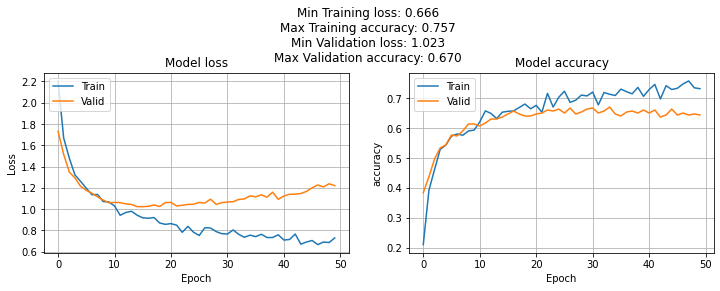

In [11]:
plot(history.history)

# Q2

- 30% of data that was `valid` is now `test`
    - will be withheld from training and validation until hyperparameters are chosen
- 70% of data that was `train` will be split into 3 folds
    - each fold will be taken as `valid` once, with the other folds as `train`

In [12]:
x_test = x_valid
y_test = y_valid
rkfold = RepeatedKFold(n_splits=3, random_state=0)

RepeatedKFold is used
- for each of the 6 `batch_sizes`
    - 3 fold is repeated 10 times
- average will be taken across this 10 sets of 3 folds as seen in the next cell

In [13]:
%%time
kfold_history = {}
batch_sizes = [1, 4, 8, 16, 32, 64]

for batch_size in batch_sizes:
    kfold_history[batch_size] = []
    for train, valid in rkfold.split(x_train):
        train_x, valid_x = x_train[train], x_train[valid]
        train_y, valid_y = y_train[train], y_train[valid]
        
        history = run_network(
            train=(train_x, train_y),
            valid=(valid_x, valid_y),
            batch_size=batch_size)
        kfold_history[batch_size].append(history)

CPU times: user 1h 5min 16s, sys: 6min 54s, total: 1h 12min 11s
Wall time: 40min 10s


Observations:
- increasing `batch_size` results in poorer best performance throughout the 50 epochs
- larger `batch_size` decreases divergence
- `batch_size=64` has smallest divergence and thus is the optimal `batch_size`

Insights:
- convergence to global minimum of cost function is slower for larger `batch_size`
- but useful information is learnt
    - weights updated to improve `train` is generalisable to `valid` as well

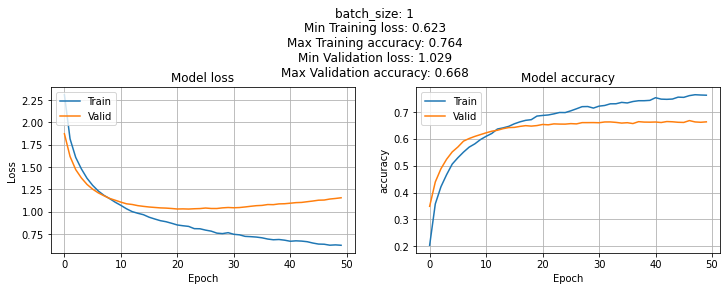

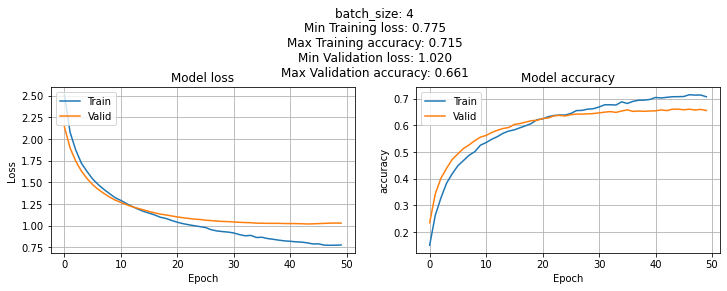

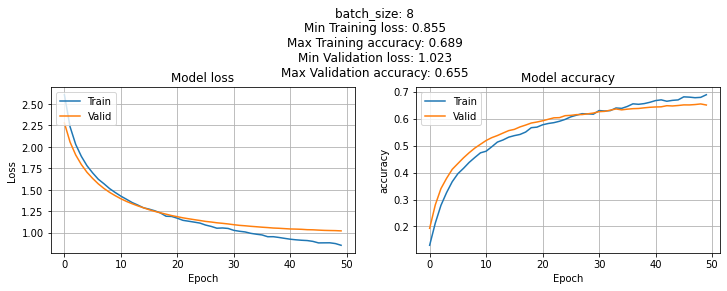

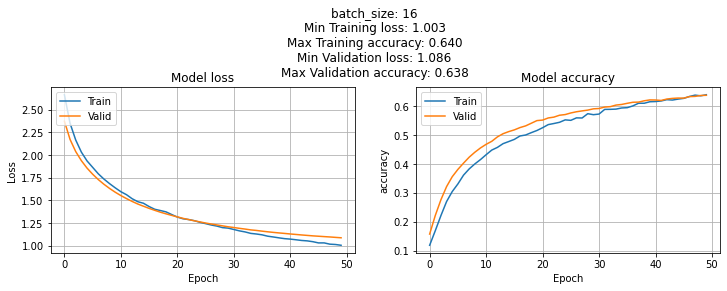

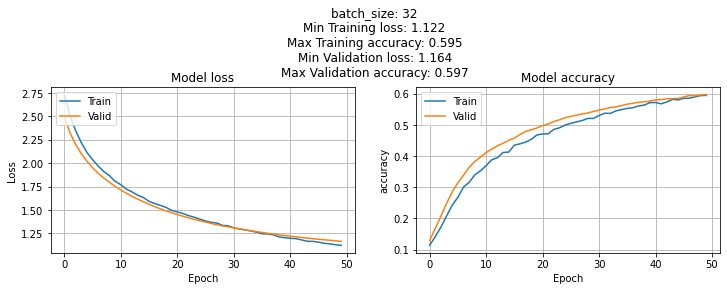

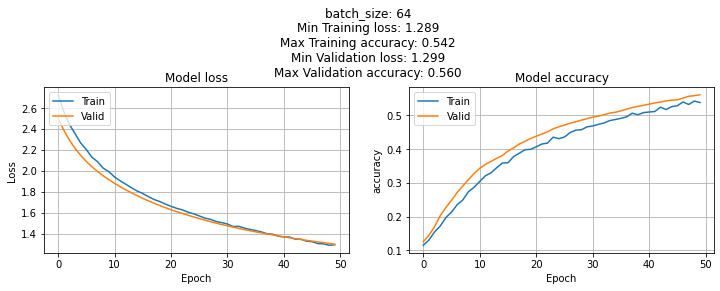

In [14]:
history = {}

for batch_size in batch_sizes:
    for key in kfold_history[1][0].history.keys():
        history[key] = np.mean(
            [h.history[key] for h in kfold_history[batch_size]],
            axis=0
        )
    plot(history, suptitle_label=f'batch_size: {batch_size}\n')

In [15]:
import time

class EpochTime(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.time_taken = []
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()
    def on_epoch_end(self, epoch, logs=None):
        self.time_taken.append(time.time() - self.start_time)

In [16]:
%%time

et = EpochTime()
for batch_size in batch_sizes:
    for train, valid in rkfold.split(x_train):
        train_x, valid_x = x_train[train], x_train[valid]
        train_y, valid_y = y_train[train], y_train[valid]
        
        history = run_network(
            train=(train_x, train_y),
            valid=(valid_x, valid_y),
            epochs=1,
            batch_size=batch_size,
            callbacks=[et]
        )

CPU times: user 2min 40s, sys: 6.06 s, total: 2min 46s
Wall time: 2min 13s


- `batch_size=64` is the fastest (due to capitalization of optimization of matrix multiplication)
    - multi core cpu parallelization
    - gpu core parallelization
- `batch_size=64` also results in better generalisation as described before

Thus `batch_size=64` is optimal

In [17]:
table = {k: [] for k in batch_sizes}
for i, t in enumerate(et.time_taken):
    table[batch_sizes[i // 30]].append(t)
    
pd.DataFrame.from_dict(table).apply(lambda x: [round(np.median(x), 2)])

,1,4,8,16,32,64
0,1.15,0.69,0.56,0.48,0.48,0.43


Now that `batch_size=64` is chosen
- retrain on `train` + `valid` and validate on `test` to get better estimate on model's performance as mentioned
- usually before deployment of model, it will be retrained on all of the data, with no data set aside for `valid` or `test`
    - since estimate of model's performance is acceptable

In [18]:
x_valid = x_test
y_valid = y_test

In [19]:
%%time
history = run_network(batch_size=64)

CPU times: user 3.08 s, sys: 296 ms, total: 3.38 s
Wall time: 2.25 s


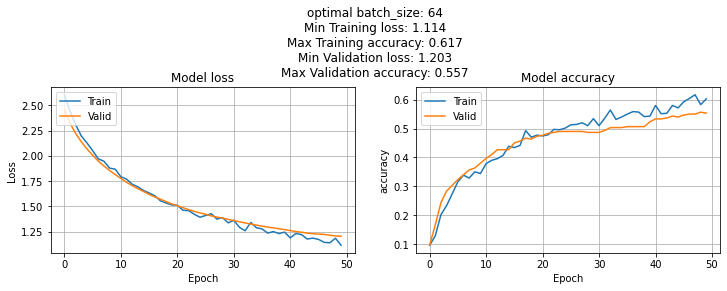

In [20]:
plot(history.history, suptitle_label=f'optimal batch_size: 64\n')

minibatch:
- capitalises on vectorisation to train faster (matrix multiplication of `batch_size` number of samples at one go)

stochastic:
- converges/diverges faster but often at local minima instead of global minima

model training:
- stochastic gradient descent is almost never used

# Q3

In [21]:
%%time
kfold_history = {}
neurons = [8, 16, 32, 64]

for neuron in neurons:
    kfold_history[neuron] = []
    for train, valid in rkfold.split(x_train):
        train_x, valid_x = x_train[train], x_train[valid]
        train_y, valid_y = y_train[train], y_train[valid]
        
        history = run_network(
            train=(train_x, train_y),
            valid=(valid_x, valid_y),
            batch_size=32,
            neurons=neuron
        )
        kfold_history[neuron].append(history)

CPU times: user 8min 34s, sys: 48.2 s, total: 9min 22s
Wall time: 5min 59s


Observations:
- `neurons=8`
    - smallest divergence and thus is the optimal `neurons`
    - similar to `batch_size=64`, valid accuracy is better than train accuracy.
       - likely due to dropout activating only in training, thus valid outperforms train
       - could also be that for `neurons=8`, `dropout=0.3` is too high
    
Insights:
- useful information is learnt
    - weights updated to improve `train` is generalisable to `valid` as well

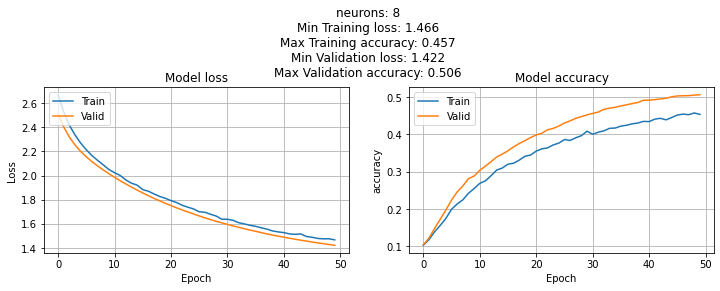

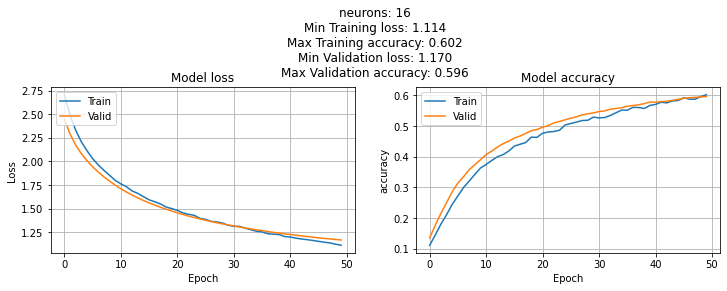

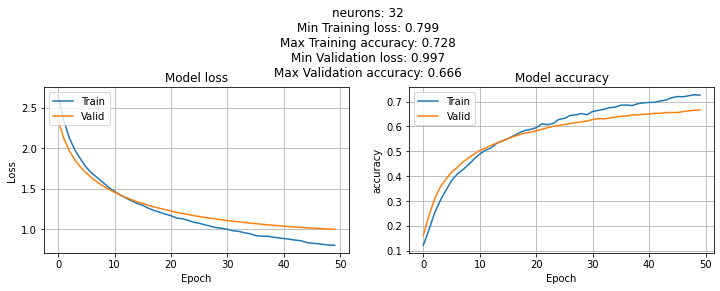

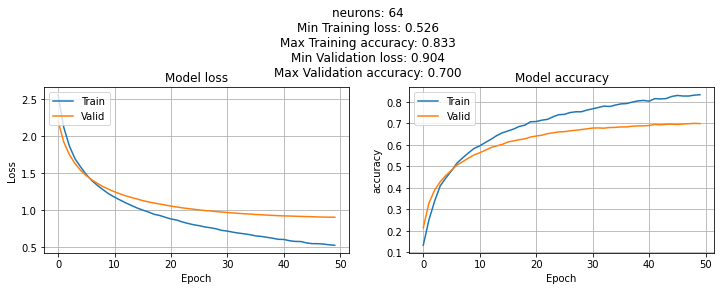

In [22]:
history = {}

for neuron in neurons:
    for key in kfold_history[8][0].history.keys():
        history[key] = np.mean(
            [h.history[key] for h in kfold_history[neuron]],
            axis=0
        )
    plot(history, suptitle_label=f'neurons: {neuron}\n')

In [23]:
%%time
history = run_network(
    batch_size=64,
    neurons=8
)

CPU times: user 3.79 s, sys: 326 ms, total: 4.12 s
Wall time: 2.88 s


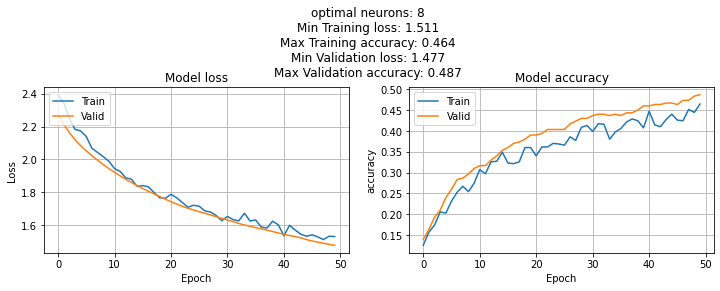

In [24]:
plot(history.history, suptitle_label=f'optimal neurons: 8\n')

Other things that can be done:
- hidden layers
    - vary number of hidden layers
    
- learning rate
    - start with `lr>1e-3` which is the default for `Adam`
    - use a learning rate scheduler to decay learning rate as epochs progress
        - big steps towards global minima at early epochs as randomly initialised weights are likely far from good
        - slowly reduce steps as epochs increase as global minima is likely close, want to give chance to find it
        
- optimizer
    - change optimizer
    - tweak optimizer params like `beta_1` for `Adam`
        - usually small improvements and/or not worth the time tweaking
        
- others
    - many other ways that will not be listed here

# Q4

In [25]:
def run_2_hidden_network(
    train=(x_train, y_train),
    valid=(x_valid, y_valid),
    dropout=.3,
    neurons=16,
    batch_size=1,
    epochs=50,
    verbose=0,
    callbacks=[],
    summary=False
):
    # clear previous models
    tf.keras.backend.clear_session()
    
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(x_train.shape[1])),
        tf.keras.layers.Dense(neurons, 'relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(neurons, 'relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(classes)
    ])
    if summary:
        return model.summary()
    
    model.compile(
        tf.optimizers.Adam(),
        metrics='accuracy',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    )
    return model.fit(
        x=train[0],
        y=train[1],
        verbose=verbose,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        validation_data=valid
    )

In [26]:
%%time
two_hidden_layer = run_2_hidden_network(summary=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                928       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                170       
Total params: 1,370
Trainable params: 1,370
Non-trainable params: 0
_________________________________________________________________
CPU times: user 45.3 ms, sys: 0 ns, total: 45.3 ms
Wall time: 42.2 ms


In [27]:
%%time
two_hidden_layer = run_2_hidden_network(
    batch_size=64,
    neurons=8
)
one_hidden_layer = run_network(
    batch_size=64,
    neurons=8
)

CPU times: user 7.13 s, sys: 702 ms, total: 7.83 s
Wall time: 5.28 s


Observations:
- two hidden layer
    - loss diverges more
- one hidden layer
    - loss diverges less
    
Insights:
- this suggests 2 hidden layers overfits on `train` more as more layers in allows for the model to memorize the `train` data and not generalize to `valid` data

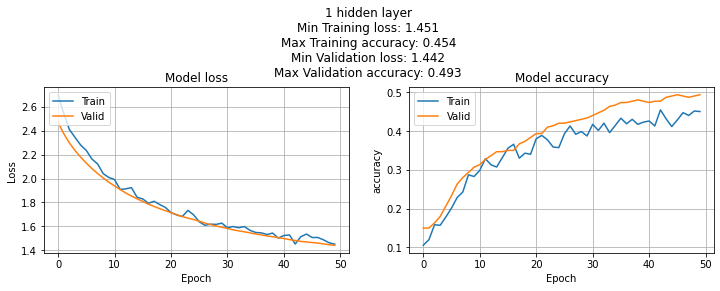

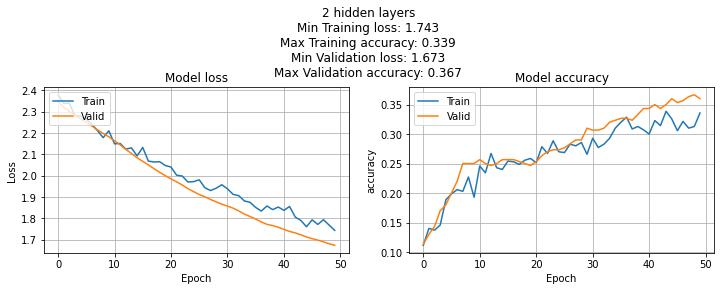

In [28]:
plot(one_hidden_layer.history, suptitle_label=f'1 hidden layer\n')
plot(two_hidden_layer.history, suptitle_label=f'2 hidden layers\n')

# Q5

In [29]:
%%time
no_dropout = run_network(dropout=0)
dropout = run_network()

CPU times: user 3min 15s, sys: 19.6 s, total: 3min 34s
Wall time: 1min 56s


- larger divergence without dropout
    - When dropout is removed, the lack of regularisation causes the model to overfit even more on `train`

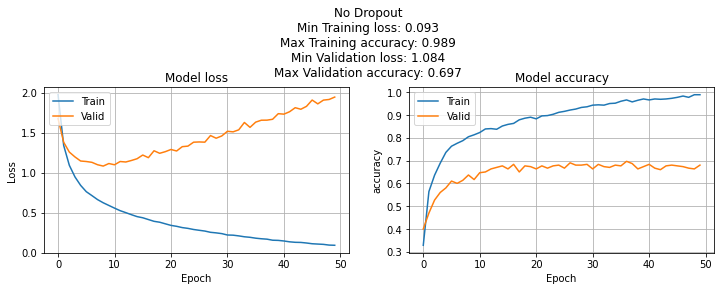

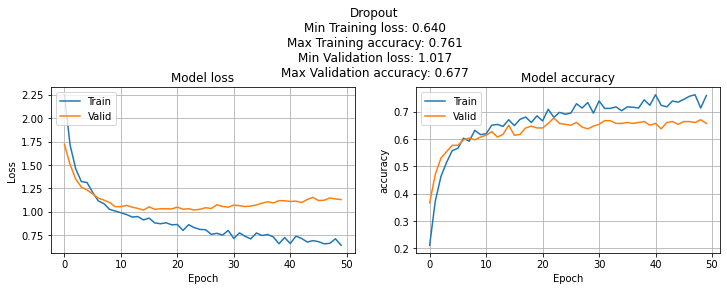

In [30]:
plot(no_dropout.history, suptitle_label=f'No Dropout\n')
plot(dropout.history, suptitle_label=f'Dropout\n')

Another approach to combat overfitting is `tf.keras.layers.BatchNormalization()`

Normalize output after first hidden layer to have each dimension in a similar scale

# Summary

Instead of using hand crafted features, deep features can be used. For example, audio files can be converted to Mel spectrograms (sample attached below). This can now be approached as a computer vision problem, where (deep) visual features are learnt from the convolutional layers and used for classification instead.

This is much more scalable as deep features are implicitly learnt; in other words, no engineer is needed to think up ways/features to describe each audio file such as harmonics, as these will be implicitly learnt in theory

![mel_sample](mel_spectrogram.png)